# Programming Exercise 8: Anomaly Detection and Recommender Systems
In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network. In the second part, you will
use collaborative filtering to build a recommender system for movies. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import random #select random samples from X
import scipy.io #Used to load the OCTAVE *.mat files
from scipy import optimize
from PIL import Image #display image from matrix '''sudo pip install pillow'''
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit as sigmod #Vectorized sigmoid function
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## 1 Anomaly detection
In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset {x(1), . . . , x(m)}. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

In [2]:
datafile = 'ex8/ex8data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
yval= mat['yval']
Xval = mat['Xval']
print('X shape = %s, Xval shape = %s, yval shape = %s' %(X.shape, Xval.shape, yval.shape,))

X shape = (307, 2), Xval shape = (307, 2), yval shape = (307, 1)


In [3]:
def plotData(X, newFigure = False):
    if(newFigure):
        plt.figure(figsize = (10,7))
    plt.plot(X[:,0], X[:,1], 'b+')
    plt.xlabel('Latency [ms]',fontsize=16)
    plt.ylabel('Throughput [mb/s]',fontsize=16)
    plt.grid(ls = '--')

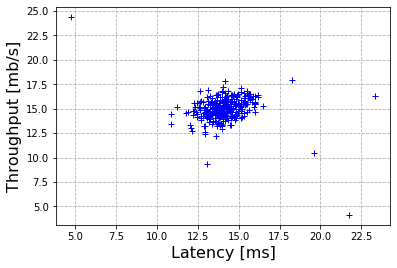

In [4]:
plotData(X)

### 1.1 Gaussian distribution

In [5]:
#X is (m,n) matrix, mu is (1,n) ndarray sigma2 = σ^2 is (n,n) ndarray
#return (m,1)
def gaussianDistribution(X, mu, sigma):
    m = X.shape[0]
    n = X.shape[1]
    if(np.ndim(sigma) == 1): #transform to use multivariate
        sigma = np.diag(sigma)
        
    coefficient = 1./np.power(2.*math.pi, n/2.) / np.sqrt(np.linalg.det(sigma)) # scalar
    d = np.zeros([m, 1]) #(m, 1)
    for i in range(m):
        d[i, :] = -1./2*(np.dot((X[i, :] - mu), np.linalg.inv(sigma)).dot((X[i, :] - mu).T))
    return coefficient * np.exp(d)

### 1.2 Estimating parameters for a Gaussian

In [6]:
#X is (m,n) darray, m examples withs each n parameters
#return mu (1,n), sigma (n,n) or mu (1,n), sigma (n,)
def getGaussianParams(X, useMultivariate = True):
    m = X.shape[0]
    n = X.shape[1]
    mu = 1./m*np.sum(X, axis = 0).reshape([1, n]) #(1, n)
    if(useMultivariate):
        sigma = 1./m*np.dot((X - mu).T, X - mu) #(n,n)
        return mu, sigma #(1,n) (n,n)
    else:
        sigma = np.sum(np.square(X - mu),axis = 0)/float(m)
        return mu, sigma #(1,n) (n,) 

#### 1.2.1 Visualizing the Gaussian probability contours

In [7]:
def plotContours(mu, sigma2,newFigure = False, useMultivariate = False):
    xvals = np.arange(0, 30, 0.1)
    yvals = np.arange(0, 30, 0.1)
    meshx, meshy = np.meshgrid(xvals, yvals)
    coord_list = [entry.ravel() for entry in (meshx, meshy)]
    points = np.vstack(coord_list).T #TODO:
    zvals = gaussianDistribution(points, mu, sigma)
    zvals = zvals.reshape(xvals.shape[0], yvals.shape[0])
    
    if(newFigure):
        plt.figure(figsize = (10,7))
    cont_levels = [10**exp for exp in range(-20,0,3)]
    plt.contour(meshx, meshy, zvals, levels = cont_levels)
    if(useMultivariate):
        plt.title('Gaussian Contours Use Multivariate', fontsize = 16)
    else:
        plt.title('Gaussian Contours Not Use Multivariate', fontsize = 16)

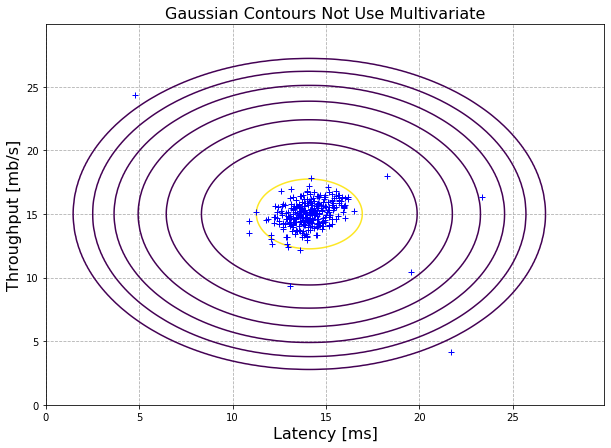

In [8]:
mu, sigma = getGaussianParams(X, useMultivariate = False)
plotData(X, newFigure = True)
plotContours(mu, sigma, newFigure = False, useMultivariate = False)

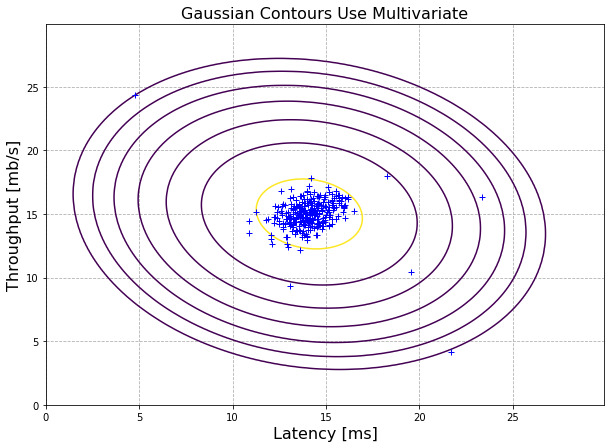

In [9]:
mu, sigma = getGaussianParams(X, useMultivariate = True)
plotData(X, newFigure = True)
plotContours(mu, sigma, newFigure = False, useMultivariate = True)

### 1.3 Selecting the threshold

In [10]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    Precision = "of all predicted y=1, what fraction had true y=1"
    Recall = "of all true y=1, what fraction predicted y=1?
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0])  if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) if trueVec[x]]) / float(np.sum(trueVec))
    return 2*P*R/(P+R) if (P+R) else 0

In [11]:
def selectThreshold(ycv,pCVs):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.
    """
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(pCVs),np.max(pCVs),nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (ycv == 1).flatten()
    for eps in epses:
        predVec = pCVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print("Best F1 is %s, best eps is %s."%(bestF1,bestEps))
    return bestF1, bestEps

In [12]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaussianDistribution(Xval, mu, sigma)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(yval,pCVs)

Best F1 is 0.8750000000000001, best eps is 9.074844572965703e-05.


In [13]:
def plotAnomalies(X, bestEps, newFigure = False, useMultivariate = True):
    ps = gaussianDistribution(X, *getGaussianParams(X, useMultivariate))
    anoms = np.array([X[x] for x in range(X.shape[0]) if ps[x] < bestEps]) #anomaly points
    if newFigure: 
        plt.figure(figsize=(10,7))
    plt.scatter(anoms[:,0],anoms[:,1], s=80, facecolors='none', edgecolors='r')

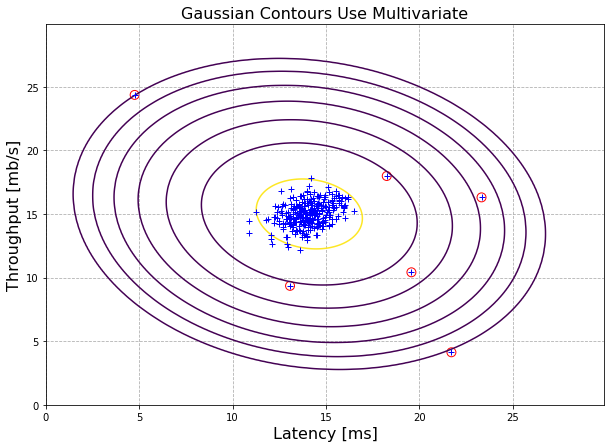

In [14]:
plotData(X, newFigure=True)
plotContours(mu, sigma, newFigure=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFigure=False, useMultivariate=True)

### 1.4 High dimensional dataset

In [15]:
datafile = 'ex8/ex8data2.mat'
mat = scipy.io.loadmat( datafile )
Xpart2 = mat['X']
ycvpart2 = mat['yval']
Xcvpart2 = mat['Xval']
print('Xpart2 shape is %s' %(Xpart2.shape,))
print('Xcvpart2 shape is %s' %(Xcvpart2.shape,))
print('ycvpart2 shape is %s' %(ycvpart2.shape,))

Xpart2 shape is (1000, 11)
Xcvpart2 shape is (100, 11)
ycvpart2 shape is (100, 1)


In [16]:
mu, sigma = getGaussianParams(Xpart2, useMultivariate=False)
ps = gaussianDistribution(Xpart2, mu, sigma)
psCV = gaussianDistribution(Xcvpart2, mu, sigma)

# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaussianDistribution(Xcvpart2, mu, sigma)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(ycvpart2,pCVs)
anoms = [Xpart2[x] for x in range(Xpart2.shape[0]) if ps[x] < bestEps]
print ('# of anomalies found:  %d' %len(anoms))

Best F1 is 0.6153846153846154, best eps is 1.3786074982000243e-18.
# of anomalies found:  117


## 2 Recommender Systems
In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset
consists of ratings on a scale of 1 to 5. The dataset has nu = 943 users, and nm = 1682 movies. 

### 2.1 Movie ratings dataset

In [17]:
datafile = 'ex8/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
nm, nu = Y.shape
print('Y shape = %s, R shape = %s' %(Y.shape, R.shape,))
print('%d users, %d movies' %(nu, nm))

Y shape = (1682, 943), R shape = (1682, 943)
943 users, 1682 movies


Average rating for movie 1 (Toy Story): 3.88


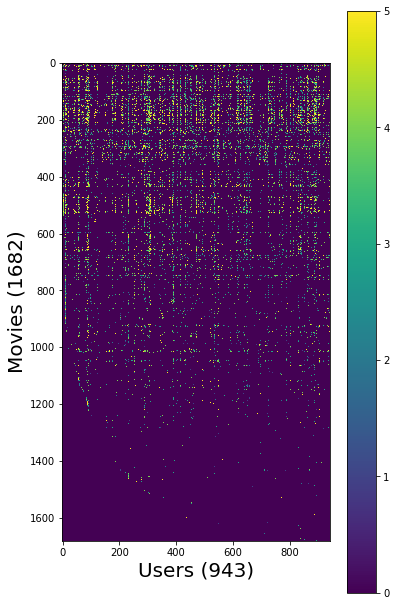

In [18]:
print('Average rating for movie 1 (Toy Story): %0.2f' % \
    np.mean([ Y[0][x] for x in range(Y.shape[1]) if R[0][x] ]))

# "Visualize the ratings matrix"
fig = plt.figure(figsize=(6,6*(1682./943.)))
plt.imshow(Y)
plt.ylabel('Movies (%d)'%nm,fontsize=20)
plt.xlabel('Users (%d)'%nu,fontsize=20)
plt.colorbar()

### 2.2 Collaborative filtering learning algorithm

In [19]:
# Read in the movie params matrices
datafile = 'ex8/ex8_movieParams.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])

# For now, reduce the data set size so that this runs faster
nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

#### 2.2.1 Collaborative filtering cost function

In [20]:
#X shape = (nm,nf) , Theta shape = (nu,nf), R shape = (nm,nu)
#nm movies, nf features, nu users
def computeCost(X, Theta , Y, R, nu, nm, nf, lamda = 0.):
    # recover the X and Theta matrices from the flattened params
    #reX, reTheta = reshapeParams(flattenedparams, nm, nu, nf)
    predMtx = np.multiply( np.dot(X, Theta.T) ,R) #set unrate movie rate 0
    cost = 0.5 * np.sum( np.square(predMtx - Y) )
    # Regularization stuff
    cost += (lamda/2.) * np.sum(np.square(Theta))
    cost += (lamda/2.) * np.sum(np.square(X))
    
    return cost

In [21]:
# "...run your cost function. You should expect to see an output of 22.22."
print('Cost with nu = 4, nm = 5, nf = 3 is %0.2f.' % \
    computeCost(X, Theta ,Y , R, nu, nm, nf))
    
# "...with lambda = 1.5 you should expect to see an output of 31.34."
print('Cost with nu = 4, nm = 5, nf = 3 (and lamda = 1.5) is %0.2f.' % \
    computeCost(X, Theta ,Y , R, nu, nm, nf, lamda=1.5))

Cost with nu = 4, nm = 5, nf = 3 is 22.22.
Cost with nu = 4, nm = 5, nf = 3 (and lamda = 1.5) is 31.34.


#### 2.2.2 Collaborative filtering gradient

In [22]:
#compute gradient , return X gradient and theta Gradient 
# X shape = (nm,nf) , Theta shape = (nu,nf),
def computeGrad(X, Theta, Y, R, nu, nm, nf, lamda = 0.):
    term1 = np.multiply(np.dot(X, Theta.T), R) - Y
    XGrad = np.dot(term1, Theta)
    ThetaGrad = np.dot(term1.T, X)
    #regularization term
    XGrad += lamda * X
    ThetaGrad += lamda *  Theta
    return XGrad, ThetaGrad

### 2.3 Learning movie recommendations

In [50]:
movies = []
with open('ex8/movie_ids.txt', encoding='ISO-8859-1') as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))
movies[:10]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)']

In [51]:
#  what was built-in to the homework
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [52]:
datafile = 'ex8/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
# We'll use 10 features
nf = 10
Y.shape

(1682, 943)

In [53]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row)
    This is important because without this, a user who hasn't rated any movies
    will have a predicted score of 0 for every movie, when in reality
    they should have a predicted score of [average score of that movie].
    """
    # The mean is only counting movies that were rated
    Ymean = np.sum(Y ,axis = 1) / np.sum(R, axis = 1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    
    return Y - Ymean, Ymean

In [54]:
myR_row = my_ratings > 0
Y = np.hstack((Y,my_ratings))
R = np.hstack((R,myR_row))
nm, nu = Y.shape

In [56]:
Ynorm, Ymean = normalizeRatings(Y,R)

In [57]:
Ynorm.shape,Ymean.shape

((1682, 944), (1682, 1))

In [58]:
# The "parameters" we are minimizing are both the elements of the
# X matrix (nm*nf) and of the Theta matrix (nu*nf)
# To use off-the-shelf minimizers we need to flatten these matrices
# into one long array
def flattenParams(X, Theta):
    """
    Hand this function an X matrix and a Theta matrix and it will flatten
    it into into one long (nm*nf + nu*nf,1) shaped numpy array
    """
    return np.concatenate((X.flatten(),Theta.flatten()))

# A utility function to re-shape the X and Theta will probably come in handy
def reshapeParams(flattenedXandTheta, nm, nu, nf):
    assert flattenedXandTheta.shape[0] == int(nm*nf+nu*nf)
    reX = flattenedXandTheta[:int(nm*nf)].reshape((nm,nf))
    reTheta = flattenedXandTheta[int(nm*nf):].reshape((nu,nf))
    return reX, reTheta

def computeFlattenedGrad(param, Y, R, nu, nm, nf, lamda = 0.):
    reX, reTheta  = reshapeParams(param, nm, nu, nf)
    XGrad, ThetaGrad = computeGrad(reX, reTheta, Y, R, nu, nm, nf, lamda = 0)
    return flattenParams(XGrad, ThetaGrad)
    
def  computeFlattenedCost(param , Y, R, nu, nm, nf, lamda = 0.):
    reX, reTheta = reshapeParams(param, nm, nu, nf)
    return computeCost(reX, reTheta, Y, R, nu, nm, nf, lamda)

In [73]:
# Generate random initial parameters, Theta and X
X = np.random.rand(nm,nf)
Theta = np.random.rand(nu,nf)
myflat = flattenParams(X, Theta)

# Regularization parameter of 10 is used (as used in the homework assignment)
lamda = 1.
x0  = flattenParams(X, Theta)

# Training the actual model with fmin_cg
result = optimize.fmin_cg(computeFlattenedCost, x0=x0, \
                            fprime=computeFlattenedGrad, \
                            args=(Y,R,nu,nm,nf,lamda), \
                            maxiter=100,disp=True,full_output=True)

         Current function value: 32205.902866
         Iterations: 96
         Function evaluations: 262
         Gradient evaluations: 249


In [74]:
# Reshape the trained output into sensible "X" and "Theta" matrices
resX, resTheta = reshapeParams(result[0], nm, nu, nf)

In [75]:
# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = resX.dot(resTheta.T)

In [76]:
# Grab the last user's predictions (since I put my predictions at the
# end of the Y matrix, not the front)
# Add back in the mean movie ratings
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [77]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

print("Top recommendations for you:")
for i in range(10):
    print('Predicting rating %0.1f for movie %s.' % \
    (my_predictions[pred_idxs_sorted[i]],movies[pred_idxs_sorted[i]]))
    
print("\nOriginal ratings provided:")
for i in range(len(my_ratings)):
    if(my_ratings[i] > 0):
        print('Rated %d for movie %s.' % (my_ratings[i],movies[i]))

Top recommendations for you:
Predicting rating 9.9 for movie They Made Me a Criminal (1939).
Predicting rating 9.8 for movie Prefontaine (1997).
Predicting rating 9.7 for movie Titanic (1997).
Predicting rating 9.6 for movie Terminator 2: Judgment Day (1991).
Predicting rating 9.4 for movie Someone Else's America (1995).
Predicting rating 9.4 for movie Raiders of the Lost Ark (1981).
Predicting rating 9.3 for movie Die Hard (1988).
Predicting rating 9.2 for movie Braveheart (1995).
Predicting rating 9.2 for movie Star Wars (1977).
Predicting rating 9.1 for movie Shawshank Redemption, The (1994).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for movie 

#### 2.3.1 Recommendations